In [24]:
import csv
import re
import urllib
from time import sleep
import pandas as pd
import numpy as np
import ast
from sklearn import cluster,metrics,manifold
import pylab as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch
from transformers import AutoConfig
from sklearn.metrics.pairwise import cosine_similarity

In [28]:
data = pd.read_csv('/Users/ruxandramihai/Desktop/abstracts_clean.csv',on_bad_lines='skip')

In [185]:
remove_id = data[data['Abstract'].str.startswith('Erratum')].index
print(len(remove_id))
data = data.drop(index=remove_id)
remove_id = data[data['Title'].str.contains(r'^(Correction:|Author Correction:)',regex=True)].index
print(len(remove_id))
data = data.drop(index=remove_id)
# drop cluster 5: DOI in Abstract
remove_id = data[data['Abstract'].str.startswith('DOI:')].index
print(len(remove_id))
data = data.drop(index=remove_id)
# drop start with Comment
remove_id = data[data['Abstract'].str.startswith('Comment ')].index
print(len(remove_id))
data = data.drop(index=remove_id)
# drop abstracts less than 
remove_id = data[data['Abstract'].str.len()<100].index
print(len(remove_id))
data = data.drop(index=remove_id)

9
25
61
21
15


/var/folders/w1/09kv9yxx35l70vmkfzryr3d40000gn/T/ipykernel_56891/3383812300.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  remove_id = data[data['Title'].str.contains(r'^(Correction:|Author Correction:)',regex=True)].index


In [ ]:
data.drop(data.columns[[0, 1]], axis=1, inplace=True)
abstracts = data['Abstract'].tolist()

In [190]:
model_config = AutoConfig.from_pretrained("/Users/ruxandramihai/Desktop/LLM/fine-tuned-pubmedBERT_5_epochs/config.json")
model = AutoModel.from_pretrained("/Users/ruxandramihai/Desktop/LLM/fine-tuned-pubmedBERT_5_epochs", config = model_config)
tokenizer = AutoTokenizer.from_pretrained("/Users/ruxandramihai/Desktop/LLM/fine-tuned-pubmedBERT_5_epochs") 

Some weights of BertModel were not initialized from the model checkpoint at /Users/ruxandramihai/Desktop/LLM/fine-tuned-pubmedBERT_5_epochs and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [192]:
inputs = tokenizer(abstracts, padding=True, truncation=True,  max_length=512, return_tensors='pt')

In [193]:
def meanpooling(output, mask):
    embeddings = output[0] # first element of model_output - token embeddings
    mask = mask.unsqueeze(-1).expand(embeddings.size()).float()
    return torch.sum(embeddings * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)

In [194]:
batch_size = 16
def process_batch(batch):
    inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = meanpooling(outputs, inputs['attention_mask'])
    return embeddings

In [195]:
# get embeddings from the abstrcts using pre-trained pubmedBERT 
all_embeddings = []
for i in range(0, len(abstracts), batch_size):
    batch = abstracts[i:i + batch_size]
    batch_embeddings = process_batch(batch)
    all_embeddings.append(batch_embeddings)
all_embeddings = torch.cat(all_embeddings, dim=0)

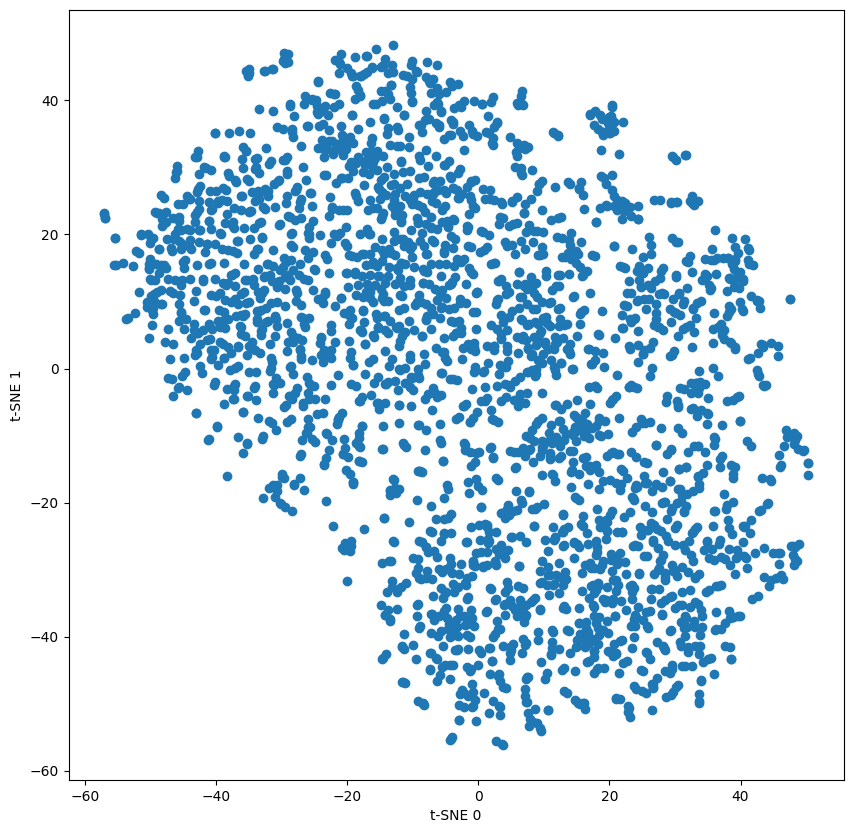

In [197]:
tsne = manifold.TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(all_embeddings)
data['tsne_0'] = embeddings_2d[:,0]
data['tsne_1'] = embeddings_2d[:,1]

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.xlabel('t-SNE 0')
plt.ylabel('t-SNE 1')
plt.show()

In [198]:
# clusters 
n_clusters = [2,5,10,15,20,25]
cluster_perf = pd.DataFrame(columns=['silhouette','calinski harabasz'],index=n_clusters)

for n_cluster in n_clusters:
    kmeans = cluster.KMeans(n_clusters = n_cluster, init='k-means++', random_state=42,n_init='auto')
    kmeans.fit(all_embeddings)
    data[f'Cluster_{n_cluster}'] = kmeans.labels_
    cluster_perf.loc[n_cluster,'calinski harabasz'] = metrics.calinski_harabasz_score(all_embeddings,data[f'Cluster_{n_cluster}'])
    cluster_perf.loc[n_cluster,'silhouette'] = metrics.silhouette_score(all_embeddings,data[f'Cluster_{n_cluster}'])

In [199]:
cluster_perf

,silhouette,calinski harabasz
2,0.112729,407.969636
5,0.051175,212.040587
10,0.040497,124.803449
15,0.039638,94.450984
20,0.036733,78.446566
25,0.028759,65.947543


In [200]:
dbscan = cluster.DBSCAN(metric='cosine',min_samples=10)
dbscan.fit(all_embeddings)
data['DBSCAN_cluster'] = dbscan.labels_

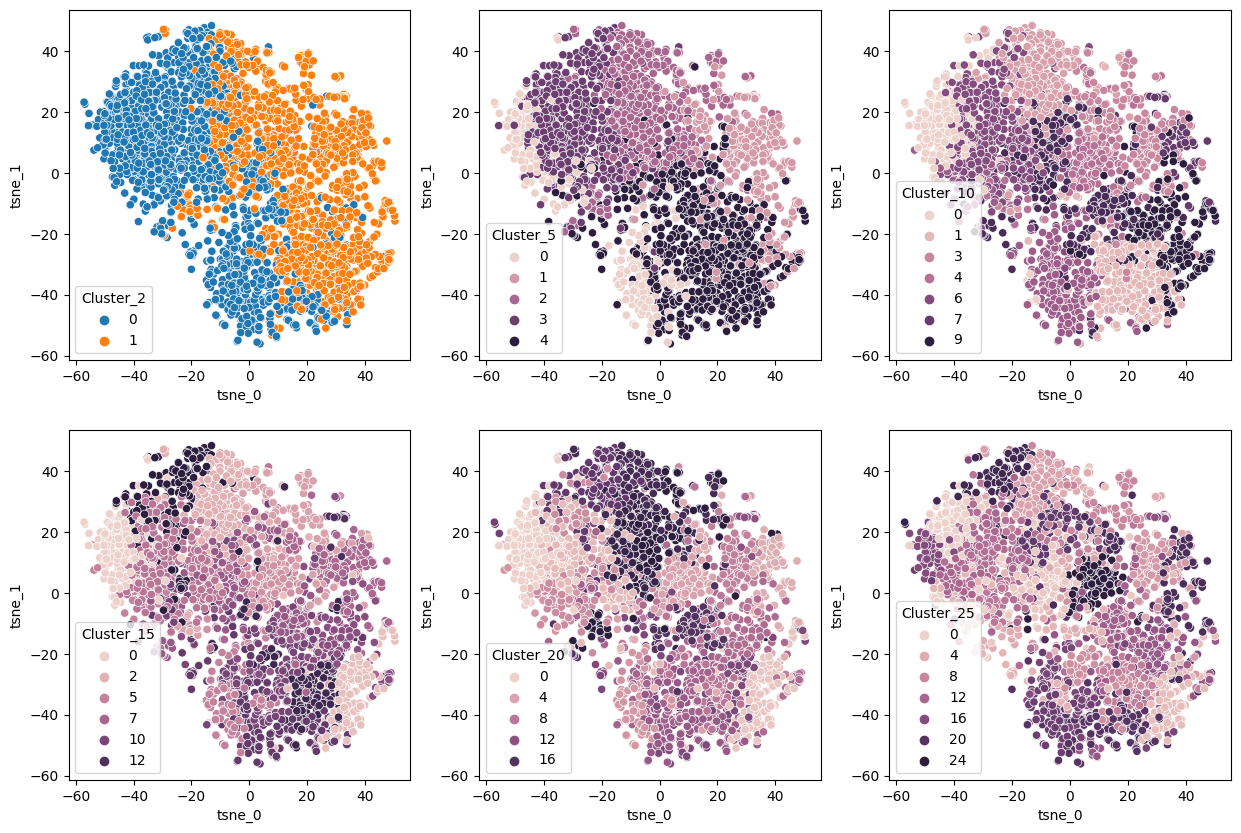

In [201]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
for ax,n_cluster in zip(axes.flatten(),n_clusters):
    sns.scatterplot(data=data,x='tsne_0',y='tsne_1',hue=f'Cluster_{n_cluster}',ax=ax)

In [202]:
data.filter(regex='Cluster_').describe()

,Cluster_2,Cluster_5,Cluster_10,Cluster_15,Cluster_20,Cluster_25
count,2753.000000,2753.000000,2753.000000,2753.000000,2753.000000,2753.000000
mean,0.485652,2.497276,4.474028,6.769706,9.136578,11.349437
std,0.499885,1.362687,2.805103,4.237841,6.160600,7.159972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
50%,0.000000,3.000000,5.000000,6.000000,9.000000,11.000000
75%,1.000000,4.000000,6.000000,10.000000,15.000000,18.000000
max,1.000000,4.000000,9.000000,14.000000,19.000000,24.000000


In [203]:
data['embeddings'] = all_embeddings.detach().cpu().numpy().tolist()

Retreival 

In [94]:
data = pd.read_csv('/Users/ruxandramihai/Desktop/RA/UK DRI Publications/embeddings.csv')
data['embeddings'] = data['embeddings'].apply(ast.literal_eval)

In [97]:
def load_embeddings():
    data = pd.read_csv('/Users/ruxandramihai/Desktop/embeddings.csv')
    data['embeddings'] = data['embeddings'].apply(ast.literal_eval)
    # drop cluster 1: all that have Erratum or Correction in Title
    remove_id = data[data['Abstract'].str.startswith('Erratum')].index
    data = data.drop(index=remove_id)
    remove_id = data[data['Title'].str.contains(r'^(Correction:|Author Correction:)',regex=True)].index
    data = data.drop(index=remove_id)
    # drop cluster 5: DOI in Abstract
    remove_id = data[data['Abstract'].str.startswith('DOI:')].index
    data = data.drop(index=remove_id)
    # drop start with Comment
    remove_id = data[data['Abstract'].str.startswith('Comment ')].index
    data = data.drop(index=remove_id)
    # drop abstracts less than 
    remove_id = data[data['Abstract'].str.len()<100].index
    data = data.drop(index=remove_id)
    embeddings = np.vstack(data['embeddings'].values)
    return data,embeddings

In [99]:
# embedding the query using the pre-trained pubmedBERT
def get_query_embedding(query):
    inputs = tokenizer(query, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state.mean(dim=1)
    return query_embedding

In [100]:
# find similar documents 
def get_kclosest(query_embedding, k=5):
    data, all_embeddings = load_embeddings()
    if isinstance(query_embedding, torch.Tensor):
        query_embedding = query_embedding.numpy()
    if isinstance(all_embeddings, torch.Tensor):
        all_embeddings = all_embeddings.numpy()
    similarities = cosine_similarity(query_embedding, all_embeddings)
    closest_indices = np.argsort(similarities[0])[-k:][::-1]
    return data.iloc[closest_indices]

In [101]:
# retrieve context - top 5 similar abstracts
def get_context(query, k=5):
    query_embedding = get_query_embedding(query)
    closest_docs = get_kclosest(query_embedding, k)
    contexts = [doc.Abstract for _, doc in closest_docs.iterrows()]
    dois = closest_docs.DOI.tolist()
    return dois, contexts

Evaluate retrieval 

In [102]:
query = "What is the effect of ApoE4 on tau PET burden?"
dois, contexts = get_context(query, k=3)

for doi, abstract in zip(dois, contexts):
    print(f"DOI: {doi}")
    print(f"Abstract: {abstract}\n")

DOI: 10.1038/s43587-023-00490-2
Abstract: The mechanisms by which the apolipoprotein E ε4 (APOEε4) allele influences the pathophysiological progression of Alzheimer's disease (AD) are poorly understood. Here we tested the association of APOEε4 carriership and amyloid-β (Aβ) burden with longitudinal tau pathology. We longitudinally assessed 94 individuals across the aging and AD spectrum who underwent clinical assessments, APOE genotyping, magnetic resonance imaging, positron emission tomography (PET) for Aβ ([18F]AZD4694) and tau ([18F]MK-6240) at baseline, as well as a 2-year follow-up tau-PET scan. We found that APOEε4 carriership potentiates Aβ effects on longitudinal tau accumulation over 2 years. The APOEε4-potentiated Aβ effects on tau-PET burden were mediated by longitudinal plasma phosphorylated tau at threonine 217 (p-tau217+) increase. This longitudinal tau accumulation as measured by PET was accompanied by brain atrophy and clinical decline. Our results suggest that the APOE

/var/folders/w1/09kv9yxx35l70vmkfzryr3d40000gn/T/ipykernel_56891/1343650358.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  remove_id = data[data['Title'].str.contains(r'^(Correction:|Author Correction:)',regex=True)].index


In [ ]:
df = pd.DataFrame({"DOI": dois, "Abstract": contexts})
pd.set_option('display.max_colwidth', None)